In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
X_all = df[[feat for feat in df.columns if feat != "Diabetes_binary"]]
Y_all = df["Diabetes_binary"]

[Text(0, 0, '218334'), Text(0, 0, '35346')]

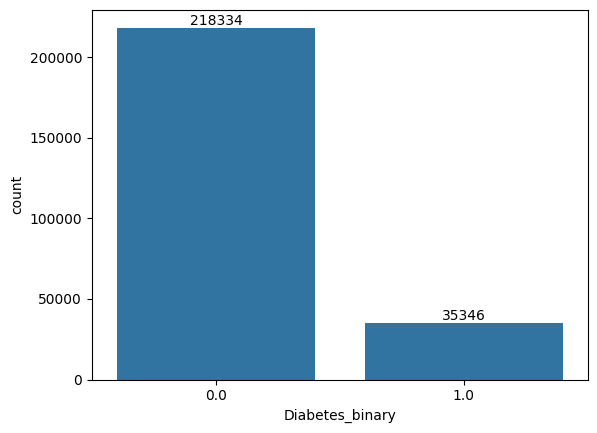

In [4]:
ax=sns.countplot(data=df, x="Diabetes_binary")
ax.bar_label(ax.containers[0])

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# Dados reservados para validação final do modelo
X, X_test, Y, y_test = train_test_split(X_all, Y_all, test_size=0.1, random_state=416, stratify=Y_all)

[Text(0, 0, '196501'), Text(0, 0, '31811')]

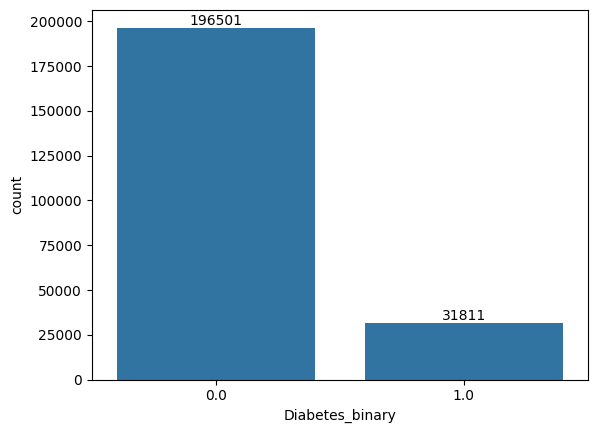

In [7]:
ax=sns.countplot(data=df.iloc[Y.index], x="Diabetes_binary")
ax.bar_label(ax.containers[0])

Fazendo testes de mudanças de parâmetros com auxílio de GridSearch

In [14]:
parameters = {
    'classifier__n_estimators':(50, 100, 200), 
    'classifier__criterion': ('gini', 'entropy', 'log_loss'),
    'classifier__max_depth': (5,10,20,None),
    'classifier__max_features': ('sqrt', 'log2')
}

In [ ]:
%%time
classifier = RandomForestClassifier(class_weight="balanced_subsample")
pipeline = Pipeline([
        ('smote', SMOTE(sampling_strategy=0.33, random_state=416)),
        ('classifier', classifier)
    ])
gridsearch = GridSearchCV(pipeline, parameters, cv=5, n_jobs=8, scoring="f1", verbose=0)
gridsearch.fit(X, Y)

In [12]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by=["mean_test_score"], ascending=False,).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,13.790714,2.028392,0.222139,0.049220,gini,10,log2,50,"{'classifier__criterion': 'gini', 'classifier_...",0.461902,0.467240,0.458134,0.460927,0.450722,0.459785,0.005408,1
11,45.197606,4.838474,0.798604,0.182540,gini,10,log2,200,"{'classifier__criterion': 'gini', 'classifier_...",0.461855,0.466540,0.459597,0.459977,0.450220,0.459638,0.005317,2
8,51.378058,6.333013,0.780951,0.158009,gini,10,sqrt,200,"{'classifier__criterion': 'gini', 'classifier_...",0.461738,0.466515,0.459451,0.460113,0.448971,0.459357,0.005751,3
6,13.542032,1.449494,0.193367,0.010246,gini,10,sqrt,50,"{'classifier__criterion': 'gini', 'classifier_...",0.460140,0.467930,0.456780,0.459758,0.451578,0.459237,0.005317,4
34,23.513769,3.457322,0.363995,0.063299,entropy,10,log2,100,"{'classifier__criterion': 'entropy', 'classifi...",0.461215,0.465958,0.458729,0.460653,0.449610,0.459233,0.005367,5


Avaliando cutoff ótimo

In [16]:
print(gridsearch.best_params_)

{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 50}


In [17]:
from tqdm import tqdm
from sklearn.metrics import f1_score, matthews_corrcoef, roc_curve, roc_auc_score, \
                            classification_report ,confusion_matrix,balanced_accuracy_score, recall_score, precision_score, precision_recall_curve

In [18]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [19]:
%%time
mccs, balan_accs, f1s, cms = [],[],[], []
precisions, recalls = [],[]
tprs, fprs, aucs = [], [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    sm = SMOTE(sampling_strategy=0.33, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    clf = RandomForestClassifier(class_weight="balanced_subsample", max_depth=10, n_estimators=50, criterion="gini", max_features="log2", n_jobs=8)
    clf.fit(X_train, Y_train)
    y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, 0.5)[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    f1s.append(f1)
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds = precision_recall_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [03:37<00:00,  2.17s/it]

CPU times: user 20min 25s, sys: 4.11 s, total: 20min 29s
Wall time: 3min 37s


In [20]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7327 +- 0.0023
ROC-AUC: 0.8228 +- 0.0017
MCC: 0.3658 +- 0.0030
F1: 0.4593 +- 0.0022
Precision: 0.3511 +- 0.0024
Recall: 0.6641 +- 0.0069


<Axes: >

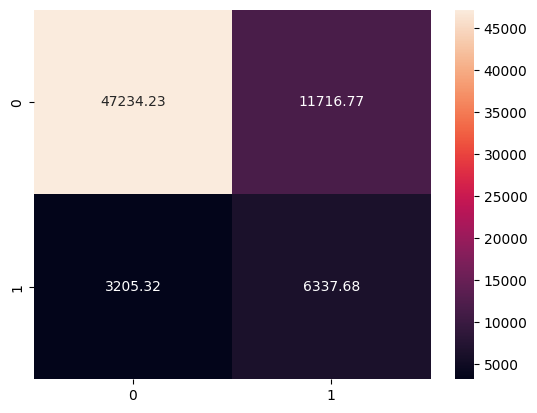

In [21]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

<Figure size 640x480 with 0 Axes>

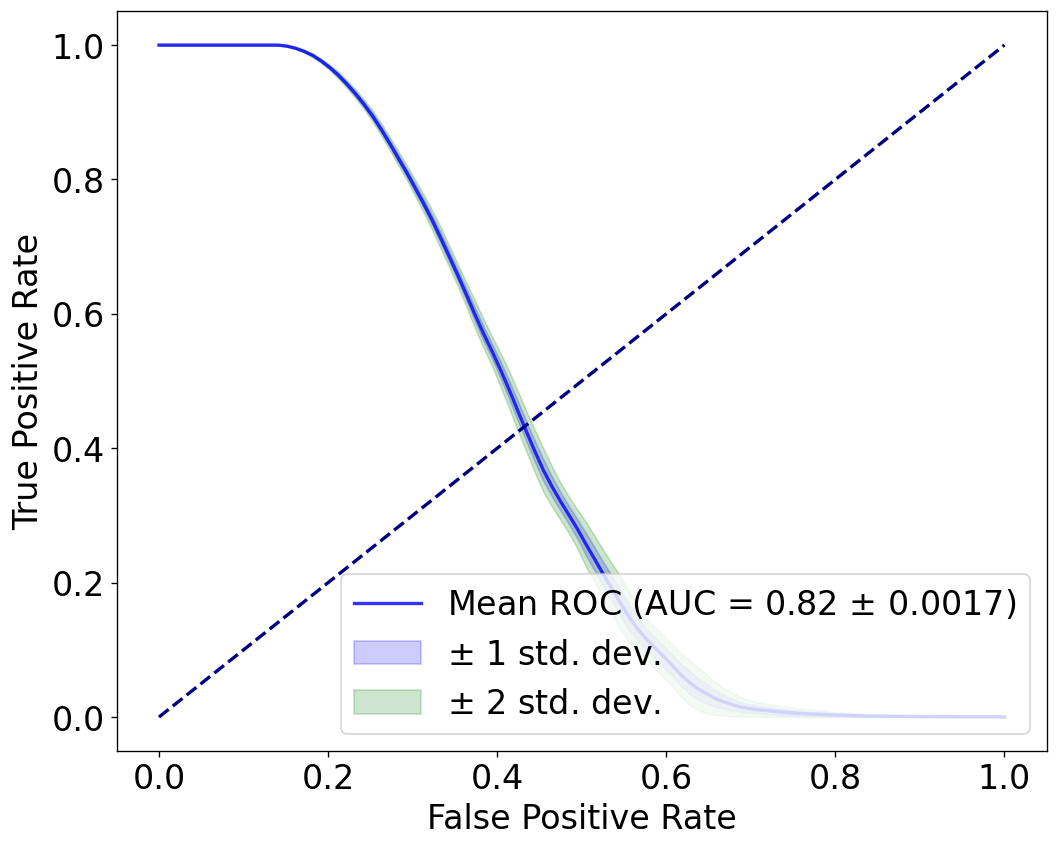

In [22]:
plt.figure()
# plt.style.use('seaborn-whitegrid')

lw = 2
plt.figure(figsize=(10, 8), dpi=120)

mean_tpr = np.mean(np.array(tprs), axis=0)
mean_fpr = np.linspace(0, 1, 100)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.4f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="blue",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr*2, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr*2, 0)

plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="green",
    alpha=0.2,
    label=r"$\pm$ 2 std. dev.",
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
# plt.title("Curva ROC", fontsize=20)
plt.legend(loc="lower right",prop={'size': 20})

Ajuste de cut-off point com F1-Score

In [26]:
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    sm = SMOTE(sampling_strategy=0.33, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    clf = RandomForestClassifier(class_weight="balanced_subsample", max_depth=10, n_estimators=50, criterion="gini", max_features="log2", n_jobs=8)
    clf.fit(X_train, Y_train)
    # y_pred_proba_train = clf.predict_proba(X_train)
    y_pred_prob = clf.predict_proba(X_val)
    scores = [f1_score(Y_val, to_labels(y_pred_prob, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_thresholds.append(thresholds[melhor_treshold])
    # y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds_ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [06:42<00:00,  4.03s/it]


In [27]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7236 +- 0.0052
ROC-AUC: 0.8229 +- 0.0016
MCC: 0.3657 +- 0.0030
F1: 0.4617 +- 0.0024
Precision: 0.3685 +- 0.0090
Recall: 0.6194 +- 0.0223


In [28]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.5333


<Axes: >

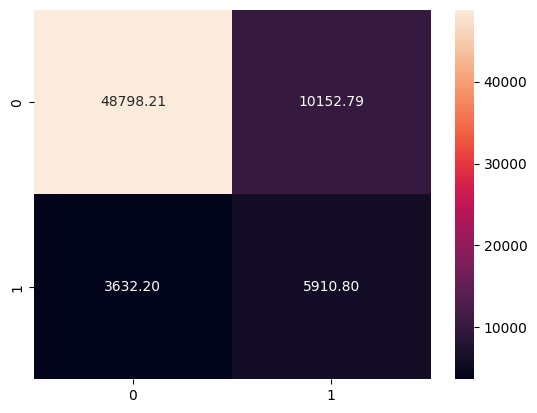

In [29]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

Ajuste de cut-off point com acurácia balanceada

In [30]:
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    sm = SMOTE(sampling_strategy=0.33, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    clf = RandomForestClassifier(class_weight="balanced_subsample", max_depth=10, n_estimators=50, criterion="gini", max_features="log2", n_jobs=8)
    clf.fit(X_train, Y_train)
    # y_pred_proba_train = clf.predict_proba(X_train)
    y_pred_prob = clf.predict_proba(X_val)
    scores = [balanced_accuracy_score(Y_val, to_labels(y_pred_prob, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_thresholds.append(thresholds[melhor_treshold])
    # y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds_ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [07:26<00:00,  4.46s/it]


In [31]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7476 +- 0.0018
ROC-AUC: 0.8228 +- 0.0017
MCC: 0.3562 +- 0.0042
F1: 0.4370 +- 0.0052
Precision: 0.3019 +- 0.0071
Recall: 0.7919 +- 0.0159


In [32]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.40199999999999997


<Axes: >

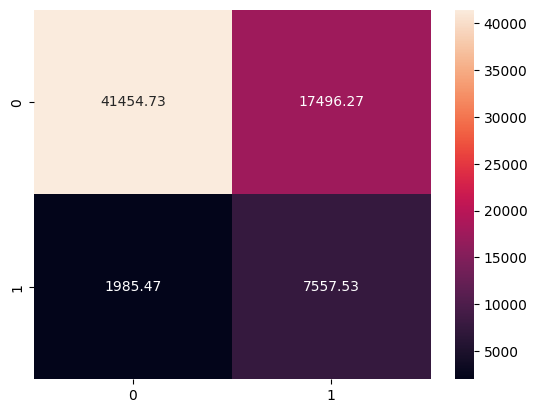

In [33]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

Ajuste de cut-off point com MCC

In [34]:
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [],[],[], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)
for i in tqdm(range(1,101)):
    sm = SMOTE(sampling_strategy=0.33, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    clf = RandomForestClassifier(class_weight="balanced_subsample", max_depth=10, n_estimators=50, criterion="gini", max_features="log2", n_jobs=8)
    clf.fit(X_train, Y_train)
    # y_pred_proba_train = clf.predict_proba(X_train)
    y_pred_prob = clf.predict_proba(X_val)
    scores = [matthews_corrcoef(Y_val, to_labels(y_pred_prob, t)[:, 1]) for t in thresholds]
    melhor_treshold = np.array(scores).argmax()
    melhores_thresholds.append(thresholds[melhor_treshold])
    # y_pred_prob = clf.predict_proba(X_val)
    y_pred = to_labels(y_pred_prob, thresholds[melhor_treshold])[:, 1]
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds_ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr); #fprs.append(fpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [06:17<00:00,  3.77s/it]


In [35]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7345 +- 0.0056
ROC-AUC: 0.8229 +- 0.0018
MCC: 0.3669 +- 0.0029
F1: 0.4593 +- 0.0032
Precision: 0.3494 +- 0.0107
Recall: 0.6723 +- 0.0285


In [36]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.49550000000000005


<Axes: >

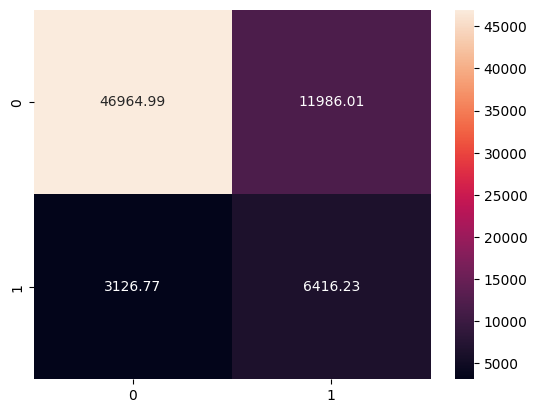

In [37]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")